<a href="https://colab.research.google.com/github/usafhulk/Deep-Learning-with-Keras-Tensorflow/blob/main/Fruit%20Class%20Transfer%20Learning%20v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fruit Classification Using Transfer Learning

### Tasks List
To achieve the above objectives, I will complete the following tasks:

- Task 1: Import necessary libraries and set dataset paths
- Task 2: Set up data generators for training, validation, and testing with augmentation
- Task 3: Define the VGG16-based model architecture with custom layers
- Task 4: Compile the model with appropriate loss and optimizer
- Task 5: Train the model with early stopping and learning rate scheduling
- Task 6: Fine-tune the model by unfreezing specific layers in VGG16
- Task 7: Evaluate the model on the test set and display accuracy
- Task 8: Visualize training performance with accuracy and loss curves
- Task 9: Test model predictions on sample images and visualize results

### Final output

The final output will be a trained deep learning model capable of classifying various fruit images into their respective categories. I will also visualize the model's accuracy and predictions on sample test images.


<h3> Dataset can be found below <h3/>
https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/rp73yg93n8-1.zip

citation: <br/>
Oltean, Mihai (2018), “Fruits 360 dataset”, Mendeley Data, V1, doi: 10.17632/rp73yg93n8.1


In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras.src.trainers.data_adapters.py_dataset_adapter")
warnings.filterwarnings("ignore", category=UserWarning, module="keras.src.trainers.epoch_iterator")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress all warnings and info messages


In [13]:
import os
import subprocess
import zipfile

# Define dataset URL and paths
url = "https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/rp73yg93n8-1.zip"
local_zip = "fruits-360-original-size.zip"
extract_dir = "fruits-360-original-size"

def download_dataset(url, output_file):
    """Download the dataset using wget in quiet mode."""
    print("Downloading the dataset...")
    subprocess.run(["wget", "-q", "-O", output_file, url], check=True)  # Add `-q` for quiet mode
    print("Download completed.")

def extract_zip_in_chunks(zip_file, extract_to, batch_size=2000):
    """
    Extract a large zip file in chunks to avoid memory bottlenecks.
    Processes a specified number of files (batch_size) at a time.
    """
    print("Extracting the dataset in chunks...")
    os.makedirs(extract_to, exist_ok=True)  # Ensure the extraction directory exists

    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        files = zip_ref.namelist()  # List all files in the archive
        total_files = len(files)

        for i in range(0, total_files, batch_size):
            batch = files[i:i+batch_size]
            for file in batch:
                zip_ref.extract(file, extract_to)  # Extract each file in the batch
            print(f"Extracted {min(i+batch_size, total_files)} of {total_files} files...")

    print(f"Dataset successfully extracted to '{extract_to}'.")

# Main script execution
if __name__ == "__main__":
    # Download the dataset if not already downloaded
    if not os.path.exists(local_zip):
        download_dataset(url, local_zip)
    else:
        print("Dataset already downloaded.")

    # Extract the dataset if not already extracted
    if not os.path.exists(extract_dir):
        extract_zip_in_chunks(local_zip, extract_dir)
    else:
        print("Dataset already extracted.")

    # Optional cleanup of the zip file
    if os.path.exists(local_zip):
        os.remove(local_zip)
        print(f"Cleaned up zip file: {local_zip}")


Download completed.
Dataset already extracted.
Cleaned up zip file: fruits-360-original-size.zip


importing essential libraries and setting up the paths for the dataset directories (train, val, and test). These libraries are necessary for data handling, model building, and performance evaluation.

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Set dataset paths
train_dir = 'fruits-360-original-size/fruits-360-original-size/Training'
val_dir = 'fruits-360-original-size/fruits-360-original-size/Validation'
test_dir = 'fruits-360-original-size/fruits-360-original-size/Test'


- `ImageDataGenerator:` For loading images and applying data augmentation.
- `VGG16:` Pre-trained model used for transfer learning.
- `Sequential:` For building a sequential model.
- `Dense, Flatten, Dropout, BatchNormalization:` Layers to customize the model architecture.
- `ReduceLROnPlateau, EarlyStopping:` Callbacks for optimizing training.

<h4> Set up data generators for training, validation, and testing with augmentation <h4>

Data generators load images from directories, rescale them, and apply augmentation on the training set to help the model generalize better. Validation and test sets are only rescaled (no augmentation).

In [5]:
# Image data generators
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical'
)


Found 6231 images belonging to 24 classes.
Found 3114 images belonging to 24 classes.
Found 3110 images belonging to 24 classes.


- `train_datagen:` Applies rescaling and augmentation (e.g., rotation, zoom) to make the model more robust.
- `val_datagen and test_datagen:` Only rescale images for validation/testing.
- `flow_from_directory:` Loads images from specified folders into batches for training/validation/testing.

<h3> Define the VGG16-based model architecture with custom layers</h3>

loading the pre-trained VGG16 model (excluding the top layers) and adding custom layers to adapt it to the fruit classification task.

In [6]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout

# Load VGG16 with pre-trained weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation='softmax')
])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


- `base_model:` Loads VGG16, excluding its dense layers (`include_top=False`).
- `for layer in base_model.layers:` Freezes VGG16 layers to retain pre-trained weights.
- Custom layers: Flatten the output, then add dense layers with regularization (Dropout) and normalization (BatchNormalization) to enhance learning.

<h3>Compile the model with appropriate loss and optimizer</h3>

Compiling the model to specify the loss function, optimizer, and evaluation metric.

In [7]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

- `categorical_crossentropy:` Used because this is a multi-class classification task.
- `adam:` Adaptive learning rate optimizer that helps in faster convergence.
- `metrics=['accuracy']:` Tracks model accuracy.

<h3> Train the model with early stopping and learning rate scheduling</h3>


Training the model, using callbacks to monitor the validation loss and adjust the learning rate or stop early to prevent overfitting.

In [8]:
import tensorflow as tf
from tensorflow.keras.mixed_precision import set_global_policy

# Define callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Enable mixed precision (if on GPU)
set_global_policy('float32')

steps_per_epoch = 50
validation_steps = 25

history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 49s 944ms/step - accuracy: 0.1761 - loss: 3.0860 - val_accuracy: 0.2125 - val_loss: 2.5962 - learning_rate: 0.0010
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 45s 901ms/step - accuracy: 0.4685 - loss: 1.6936 - val_accuracy: 0.3800 - val_loss: 2.1658 - learning_rate: 0.0010
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.5642 - loss: 1.3501 - val_accuracy: 0.3550 - val_loss: 1.8501 - learning_rate: 0.0010
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.6782 - loss: 1.0141 - val_accuracy: 0.5325 - val_loss: 1.5454 - learning_rate: 0.0010
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.7263 - loss: 0.8807 - val_accuracy: 0.6550 - val_loss: 1.1403 - learning_rate: 0.0010


- `ReduceLROnPlateau`: Reduces learning rate when validation loss plateaus, allowing better optimization.
- `EarlyStopping`: Stops training when validation loss no longer improves, preventing overfitting.
- `model.fit`: Trains the model on the `train_generator` and evaluates on `val_generator` each epoch.

<h3> Fine-tune the model by unfreezing specific layers in VGG16</h3>

Fine-tuneing by unfreezing a few layers in the VGG16 base model to allow learning on fruit-specific features.


In [9]:
# Import necessary libraries
import tensorflow as tf  # Import TensorFlow for accessing tf.keras
from tensorflow.keras.optimizers import Adam

# Check the number of layers in the base model
num_layers = len(base_model.layers)
print(f"The base model has {num_layers} layers.")

# Unfreeze the last 5 layers for fine-tuning
for layer in base_model.layers[-5:]:
    layer.trainable = True

# Freeze BatchNorm layers to speed up fine-tuning
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

# Re-compile the model with a faster optimizer
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),   # Higher learning rate for faster convergence
    metrics=['accuracy']
)

# Continue training with fewer steps per epoch
history_fine = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch,  # Reduced steps per epoch
    validation_steps=validation_steps,  # Reduced validation steps
    callbacks=[lr_scheduler, early_stopping]
)

The base model has 19 layers.
Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.7718 - loss: 0.7805 - val_accuracy: 0.6550 - val_loss: 1.0338 - learning_rate: 1.0000e-05
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.7783 - loss: 0.6777 - val_accuracy: 0.7925 - val_loss: 0.6954 - learning_rate: 1.0000e-05
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7845 - loss: 0.6250 - val_accuracy: 0.8500 - val_loss: 0.5453 - learning_rate: 1.0000e-05
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8143 - loss: 0.5535 - val_accuracy: 0.8075 - val_loss: 0.6533 - learning_rate: 1.0000e-05
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8497 - loss: 0.4849 - val_accuracy: 0.8400 - val_loss: 0.5297 - learning_rate: 1.0000e-05


- `for layer in base_model.layers[-5:]`: Unfreezes the last 5 layers to allow fine-tuning.
-  Unfreezing fewer layers is faster and prevents overfitting on small datasets.
- `RMSprop(learning_rate=1e-5)`: Optimizer with a lower learning rate to fine-tune carefully without drastic weight changes.

<h3> Evaluate the model on the test set and display accuracy</h3>


Evaluates the final model on unseen test data to gauge its generalization.

In [10]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=50)
print(f"Test Accuracy: {test_accuracy:.2f}")


50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 601ms/step - accuracy: 0.8438 - loss: 0.5783
Test Accuracy: 0.83


- `model.evaluate(test_generator)`: Evaluates the model on the test set and prints accuracy, giving a final measure of model performance.

<h3> Visualize training performance with accuracy and loss curves </h3>
Plots the training and validation accuracy and loss to understand the model’s learning progress.

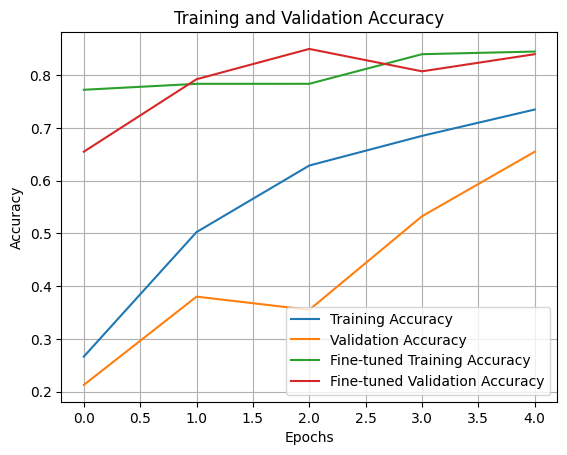

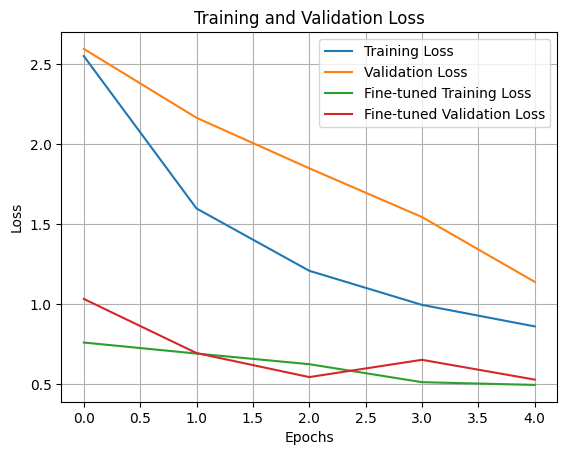

In [11]:
# Plot accuracy and loss curves
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_fine.history['accuracy'], label='Fine-tuned Training Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Fine-tuned Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history_fine.history['loss'], label='Fine-tuned Training Loss')
plt.plot(history_fine.history['val_loss'], label='Fine-tuned Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)
plt.show()

- `plt.plot`: Plots the accuracy and loss for training and validation over epochs.
  
- Visual comparison shows if the model is overfitting, underfitting, or learning effectively.


<h3> Test model predictions on sample images and visualize results</h3>

Makes predictions on a few test images and displays them with the model's predicted class.

Class Index Mapping: {'apple_6': 0, 'apple_braeburn_1': 1, 'apple_crimson_snow_1': 2, 'apple_golden_1': 3, 'apple_golden_2': 4, 'apple_golden_3': 5, 'apple_granny_smith_1': 6, 'apple_hit_1': 7, 'apple_pink_lady_1': 8, 'apple_red_1': 9, 'apple_red_2': 10, 'apple_red_3': 11, 'apple_red_delicios_1': 12, 'apple_red_yellow_1': 13, 'apple_rotten_1': 14, 'cabbage_white_1': 15, 'carrot_1': 16, 'cucumber_1': 17, 'cucumber_3': 18, 'eggplant_violet_1': 19, 'pear_1': 20, 'pear_3': 21, 'zucchini_1': 22, 'zucchini_dark_1': 23}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


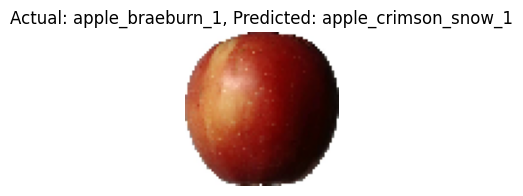

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


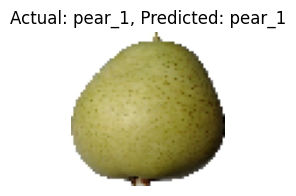

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


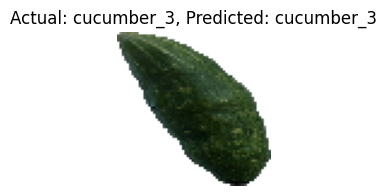

In [12]:
import os
import numpy as np
from collections import Counter
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt

# Initialize counters for actual and predicted classes
actual_count = Counter()
predicted_count = Counter()

# Function to get class name from predicted index
def get_class_name_from_index(predicted_index, class_index_mapping):
    """Convert predicted index to class name."""
    for class_name, index in class_index_mapping.items():
        if index == predicted_index:
            return class_name
    return "Unknown"  # Default if index is not found

# Define the function for visualization
def visualize_prediction_with_actual(img_path, class_index_mapping):
    # Extract the true label dynamically from the directory structure
    class_name = os.path.basename(os.path.dirname(img_path))  # Extract folder name (class)

    # Load and preprocess the image
    img = load_img(img_path, target_size=(64, 64))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict the class
    prediction = model.predict(img_array)
    predicted_index = np.argmax(prediction, axis=-1)[0]
    predicted_class_name = get_class_name_from_index(predicted_index, class_index_mapping)

    # Update the counters
    actual_count[class_name] += 1
    predicted_count[predicted_class_name] += 1

    # Visualize the image with predictions
    plt.figure(figsize=(2, 2), dpi=100)
    plt.imshow(img)
    plt.title(f"Actual: {class_name}, Predicted: {predicted_class_name}")
    plt.axis('off')
    plt.show()

# Retrieve class index mapping from the training generator
class_index_mapping = train_generator.class_indices
print("Class Index Mapping:", class_index_mapping)  # Debugging: Check the mapping

# Define a list of image paths without hardcoded labels
sample_images = [
    'fruits-360-original-size/fruits-360-original-size/Test/apple_braeburn_1/r0_11.jpg',
    'fruits-360-original-size/fruits-360-original-size/Test/pear_1/r0_103.jpg',
    'fruits-360-original-size/fruits-360-original-size/Test/cucumber_3/r0_103.jpg',
]

# Run the predictions and visualization
for img_path in sample_images:
    visualize_prediction_with_actual(img_path, class_index_mapping)


- `visualize_prediction`: Loads an image, preprocesses it, predicts its class, and displays it.
  
- `model.predict(img_array)`: Uses the trained model to make predictions on unseen images.

##### If there is an incorrect prediction during testing, the following factors could contribute to the misclassification:

Class Similarity: Visually similar fruit classes (e.g., apple types) can confuse the model.

Insufficient Data: Imbalanced datasets with fewer samples for certain classes may cause underfitting.

Limited Training: Fine-tuning fewer layers might not capture sufficient class-specific features.

Data Augmentation Impact: Aggressive augmentations may distort key features, reducing accuracy for specific images.